Our second try on the DengAI Data Science Challenge

## Background Information

This post represents one out of two posts in which we are discussing our second attempt on the Data Science Challenge: DengAI from Drivendata.org, which can be found [here](https://www.drivendata.org/competitions/44/dengai-predicting-disease-spread/).

In this challenge we are asked to predict the number of dengue fever in the two cities San Juan and Iquitos given time-series data of several feature variables with around ~900 and ~500 observations for each city respectively. On the website we also find some more information about the disease:

*'Dengue fever is a mosquito-borne disease that occurs in tropical and sub-tropical parts of the world. In mild cases, symptoms are similar to the flu: fever, rash, and muscle and joint pain. In severe cases, dengue fever can cause severe bleeding, low blood pressure, and even death.'*

Especially challenging in this competition is, that we are asked to provide forecasts for around ~250 and ~150 observations in the future respectively. The long-term forecast seems especially challenging when considering that we do not have that many observations to train our model. 

This challenge definitely is one of the more popular ones on DrivenData.org, having more than 10.000 participating teams as of April 2021.

## Structure of this post

We begin this post by taking a look at the target variable and discuss what makes the prediction of that time-series so difficult. Afterwards we discuss our key learnings from our last attempt on this challenge and what we aim to improve this time.

The second part of this post then discussing the prediction methodology and shows its implementation into code. 


### Target variable

One of the first steps before deciding on the strategy of the forecasting methodology is to take a thorough look at the target variable. As mentioned already earlier, we are facing a panel dataset in this challenge. *Panel data* means we have time-series data for multiple entities, namely for the two cities San Juan and Iquitos.

In order to get a first idea of the target variable we are facing, we show in the following the target variable for both cities: San Juan (left) and Iquitos (right).

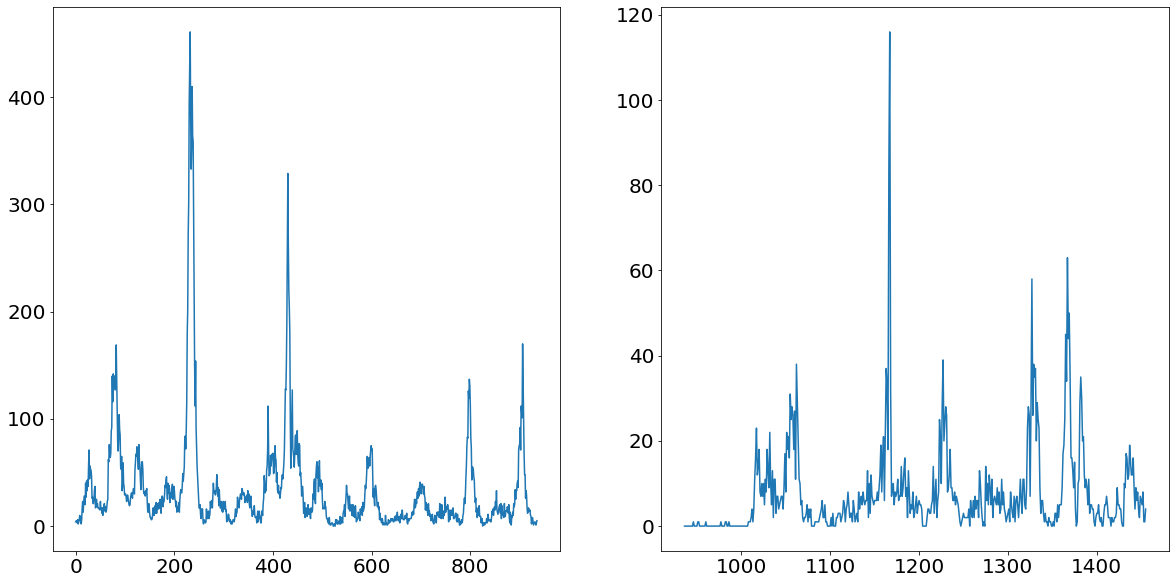

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt

os.chdir(r"/Users/PM/Documents/Projects/dengai_ensemble/")
import src._config # Contains matplotlib settings to be applied to all graphs

target_data = pd.read_csv("data/dengue_labels_train.csv")
city_names = set(target_data.loc[:, "city"])
n_cities = len(city_names)
fig, axs = plt.subplots(figsize=(10*n_cities, 10), ncols=n_cities)
axs = axs.ravel()
for i, city in enumerate(city_names):
    city_data = target_data.query("city==@city").loc[:, "total_cases"]
    axs[i].plot(city_data) 

From the chart above we can nicely see that both time series follow a somewhat yearly seasonality. That would make sense as we would assume that the mosquito population is peaking every summer and nearly extinct in the winter times. What is even more apparent are the massive spikes in the time series. It seems that in a non-periodic cycle the number of dengue fever cases just explode.

Given the magnitude of those spikes, failing to predict them makes all the difference between a good and a bad prediction model.

## One model for both cities vs. One model for each city

When facing panel data, the question arises whether we build one model for each entity, or whether we use one model for both entities. Training one model for both entities would potentially come with the benefit of having cross-learning opportunities. Meaning that the prediction for one entity would be enhanced when using the trainings data from another entity. This is only possible though if the data generating process is the same.

If the distribution between entities is fundamentally different, then any prediction model will have a hard time trying to predict to significantly different time-series. For the purpose of testing whether the two distributions are fundamentally different we are using a Kolmogrov Smirnov test. From the strongly significant p-value we conclude that the data generating process is not the same and therefore decide to train two individual prediction models.

In [2]:
from scipy import stats

san_juan = target_data.query('city=="sj"').loc[:, "total_cases"]
iquitos = target_data.query('city=="iq"').loc[:, "total_cases"]
stats.ks_2samp(san_juan, iquitos)

Ks_2sampResult(statistic=0.5068376068376068, pvalue=4.7991921470916946e-76)

## Learnings from previous attempt

Given that we already tried ourselves on the DengAI challenge in the past, it is worthwhile to talk about what has been tried, what went wrong and what could be improved for the next attempt.

During our last attempt we build a [STL Forecasting model](https://www.statsmodels.org/stable/generated/statsmodels.tsa.forecasting.stl.STLForecast.html) with an underlying ARIMA model. The ARIMA was parameterized using the Box-Jenkins methodology, which is the go-to method when doing that.

The flaw of this model, or any ARIMA model for that matter, is that those models are not designed for long-term forecasts. That is because ARIMA models are mean-reverting and therefore useless when it comes to forecasts longer than a few periods. Especially with time-series which are as bumpy as the ones we are trying to predict, this forecasting method was wrongly placed.

Below we see that out-of-sample predictions from our model for the city San Juan. The out-of-sample prediction were produced by using the first 80% of the data for training purposes and applying the parameterized model then on the remaining 20%.

As we can see, the MAE of around 15.7 is actually not too bad, though we are failing to accurately predict the spikes.

![Forecasting for out-of-sample San Juan](images/last_attempt_forecast.png)

One positive aspect of our last attempt was to for allow multiple seasonalities through the STL part of the model. STL or *seasonal-trend decomposition using LOESS* is normally used to decompose a time series into its three components: seasonality, trend and residual. Splitting a time-series into its components comes handy when trying to make the series stationary, which normally would involve removing the trend and potentially even it's seasonality.

The benefit of allowing for multiple seasonalities becomes particularly apparent when plotting a **power-spectrum** for both time-series. A power-spectrum gives us an idea what the driving frequencies of a series are. This concept is easier understood when imaging that we are not dealing with dengue cases over time, but rather with the the sound wave of a song. All (interesting) songs consist out of multiple different sounds, which are all reflected within the song wave. Looking at a sound wave, it is difficult to point at the frequency is the most dominant one. In order to split the sound wave into its frequency components we are using a so-called [Fourier Transform](https://en.wikipedia.org/wiki/Fourier_transform). To then find out what the dominant frequencies are, we set a so-called *prominence level*. This prominence level serves us as a threshold, in order to find out what the driving frequencies are.

This concept is also applicable to time-series problems in order to find out which seasonality is dominant within the series. The following code plots the power-spectrum for the two time-series.

We decided threshold to two standard deviations above the median. We chose the median in contrast to using the mean, given the heavy skewness the time-series suffers from. These thresholds are always tricky to set, and will always end up being subjective.

The relevant frequencies for sj is/are: [187.2, 93.6, 52.0, 33.42857142857142]
The relevant frequencies for iq is/are: [52.0]


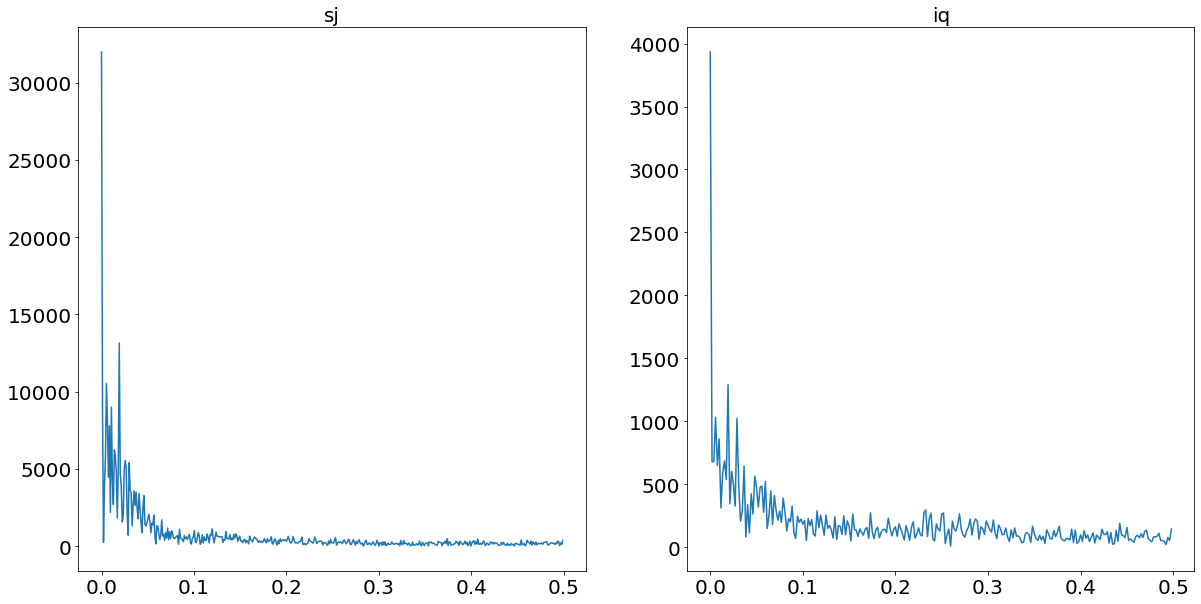

In [3]:
import numpy as np
from scipy import signal as sig

city_data = target_data.query("city==@city").loc[:, "total_cases"]

fig, axs = plt.subplots(figsize=(10*n_cities, 10), ncols=n_cities)
axs = axs.ravel()
for i, city in enumerate(city_names):
    signal = target_data.query("city==@city").loc[:, "total_cases"]

    fft = np.fft.fft(signal)
    magnitude = np.abs(fft)
    frequency = np.fft.fftfreq(len(signal))

    left_magnitude = magnitude[:int(len(magnitude)/2)]
    left_frequency = frequency[:int(len(frequency)/2)]

    prominence = np.median(left_magnitude) + 2 * np.std(left_magnitude)
    peaks = sig.find_peaks(left_magnitude[left_frequency >= 0], prominence=prominence)[0]
    peak_freq = left_frequency[peaks]
    list_frequencies = (1/peak_freq).tolist()

    axs[i].plot(left_frequency, left_magnitude)
    axs[i].set_title(city)
    print(f"The relevant frequencies for {city} is/are: {list_frequencies}")

From the print statement above we see that we find yearly seasonality for Iquitos, and four different and prominent frequencies for San Juan. This finding supports our hypothesis of the benefit of a model which allows for multiple seasonalities.

## Forecasting Methodology

The inspiration for our new modeling approach came during one of the brain-storming sessions at work. At the time we were working for a large insurance company and we were building a claims forecasting model.

The business model of an insurer relies on the foundations that most people do not have to make use of their insurance most of the time. That means that in most months the customers of an insurer simply pays into the insurance without filling any claims. That means that most entries of the claims data of an insurance are zero. A phenomena which Data Scientists would describe as *'sparse'* data.

That sparsity makes it significantly more difficult to predict the claims variable. Academia provides us with several suggestions on how to tackle this problem. One potential approach to model that behavior is suggested in the paper of Andrea Andrea Dal Pozzolo 2010 [1]. Herein the author splits the forecasting problem into two different parts. Firstly, a classification problems in which we classify whether the claim is having a payout or not. In the second step we apply a regression model to the observations which are non-zero.

The benefit of this approach is that the regression model could focus more on observations which are non-zero and therefore is able to better cope with the spikes within the target.

Applying this approach on our data is not as straightforward. That is mainly because of two reasons: 

1. Classification Problem: In contrast to the insurance claims data we do not find many (if any at all) observations which have a target value of zero
2. Time-series Problem: In contrast to the outlined paper we face time-series data instead of cross-sectional data

These two questions are outlined in the following two sections.

### 1. Classification Problem
To address those problems the following idea was drafted. Instead of trying to figure out which observations are non-zero, we try in a first instance to figure out which observation belongs to an unusual high level within the time-series, aka dengue outbursts.

We do that by separating the target variable into *outliers* and *non-outliers*. For example, we define every observation above the e.g. 90th percentile as *outliers* and all of the other observations as *non-outliers*. By doing that we turned the target variable from an integer to a binary, which allows us to apply a classification model. Afterwards, we apply a regression model on only those observations which are predicted to belong to the *outliers* class.

Below we show how exactly that separation would look like when using the 90th percentile as the threshold between *outliers* and *non-outliers*.

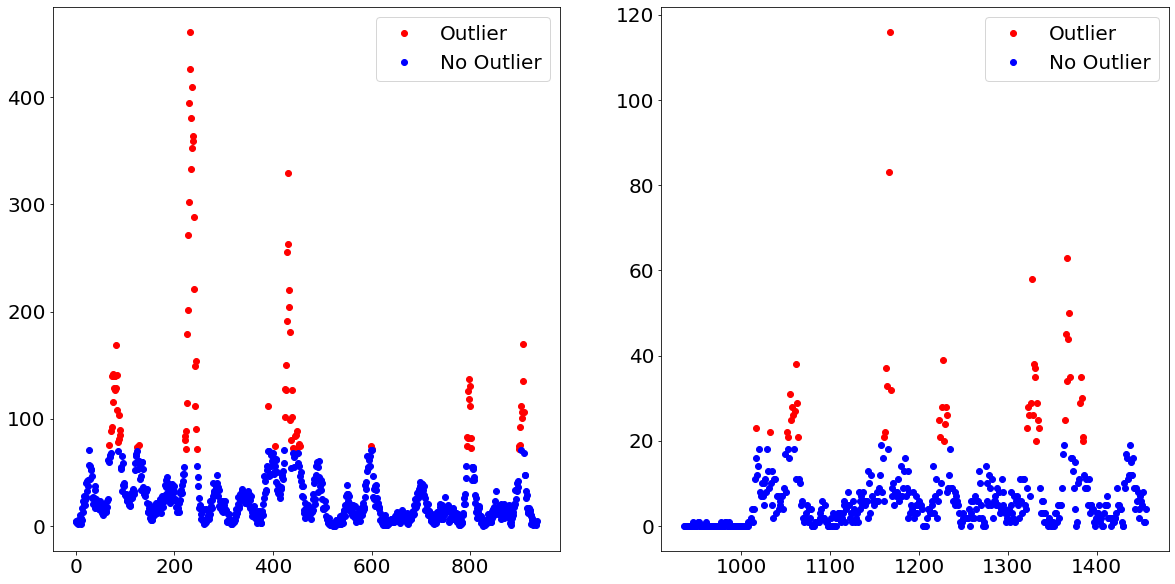

In [4]:
import numpy as np

THRESHOLD = 90
fig, axs = plt.subplots(figsize=(10*n_cities, 10), ncols=n_cities)
axs = axs.ravel()
for i, city in enumerate(city_names):
    city_data = target_data.query("city==@city").loc[:, "total_cases"]
    level_threshold = np.percentile(city_data, THRESHOLD)
    bool_threshold = city_data > level_threshold
    axs[i].plot(city_data[bool_threshold], color="red", label="Outlier", linestyle="None", marker="o")
    axs[i].plot(city_data[~bool_threshold], color="blue", label="No Outlier", linestyle="None", marker="o")
    axs[i].legend()

### 2. Time-Series Problem

The other problem we are facing is that we are dealing with a time-series problem in contrast to a cross-sectional problem we had in the insurance context.

When predicting which observation belongs to the *outliers* group, we are treating the problem as if it were a cross-sectional problem. Hence, ignoring the time component altogether.

Afterwards, we are predicting the *outliers* group through a regression model. For the *non-outliers* group, which will represent the majority of the observations, we will use a time-series prediction model. In order to be able to do that, we have to have a time-series with no missing observations. Though, in order for the *outliers* not to affect the *non-outliers* prediction method, we have to replace the extreme values. This is done through a method called [**winsorizing**](https://en.wikipedia.org/wiki/Winsorizing).

What this method does is that it cuts off everything above the Xth percentile and replaces the values with the value of exactly this Xth percentile. In the image below we show an example how the time-series of the *non-outliers* would look like if we winsorize at the 90th percentile level.

The orange line shows nicely how everything above a certain absolute level is cut-off and replaced. This newly created series is then what we predict using the TBATS model.

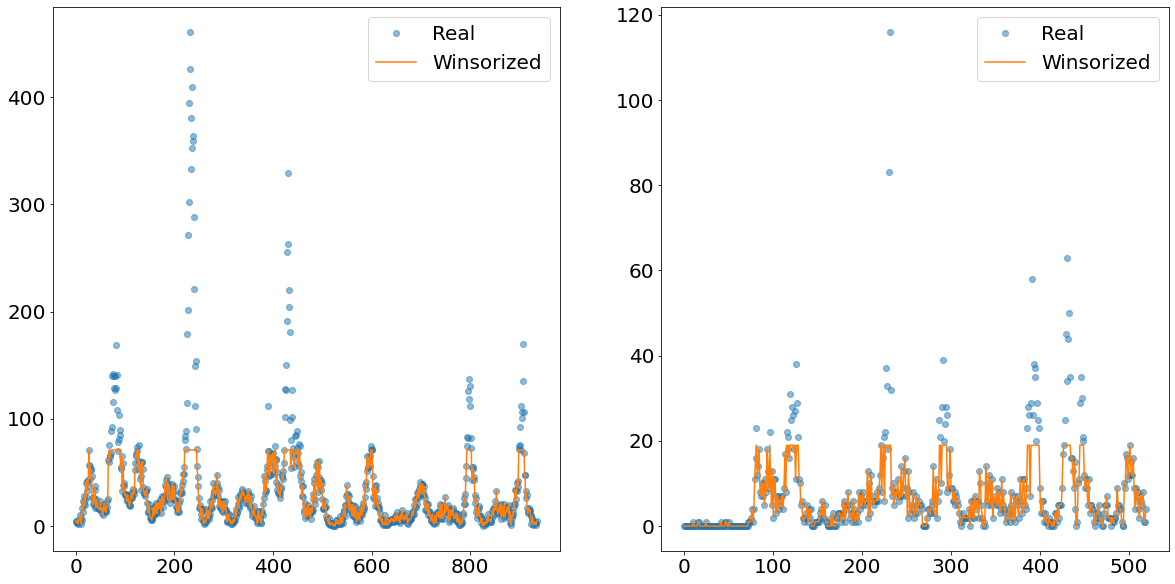

In [5]:
from scipy.stats.mstats import winsorize

def winsorize_data(data, upper_threshold):
    """This function cuts the data at the upper threshold"""
    one_minus_upper_bound = 1-(upper_threshold/100)
    cutted_data = winsorize(data, limits=[0, one_minus_upper_bound], inclusive=(True, False)).data
    return cutted_data

THRESHOLD = 90
fig, axs = plt.subplots(figsize=(10*n_cities, 10), ncols=n_cities)
axs = axs.ravel()
for i, city in enumerate(city_names):
    city_data = target_data.query("city==@city").loc[:, "total_cases"]
    winsorized_data = winsorize_data(city_data, THRESHOLD)
    axs[i].plot(city_data.values, label="Real", linestyle="None", marker="o", alpha=0.5)
    axs[i].plot(winsorized_data, label="Winsorized")
    axs[i].legend()

## Oversampling

After dealing with the time-series problems, it is now time to address a problem occurring within the classification of *outliers* and *non-outliers*, namely the heavy imbalanced data. Imbalanced data describes the situation within classification problems, in which we have significantly more observations from one class compared to another class. This would impact our model-performance, as the model does not have a sufficient amount of *outliers* observations to properly learn which statistical properties constitute the concept of *outliers*.

In order to combat that problem, there are multiple approaches of how to tackle that. We could for instance undersample the majority class (i.e. *non-outliers*), or alternatively, oversample the minority class. We decided to go with the later approach, but use a synthetic oversampler instead of using random sampling.

Synthetic minority oversampling describes a technique in which new observations of the minority classes are created by finding observations which are “like” the existing ones, but are not completely identical. One of the most popular methods is called **SMOTE**, which stands for Synthetic Minority Oversampling Technique.

The exact workings and visualization of how SMOTE works will be outlined in a separate post, but the basic idea is quickly understood: One imagines that we only have two features and we plot all observations on a scatter plot, having each feature on one axes. The next step is then to draw connecting lines between every observation. The newly created values would then be found on these connection lines. This strategy is only one of many potential ways of how to use the SMOTE oversampling technique.

One quite important parameter within all oversample techniques is called the **sampling_strategy**. This parameter describes how big the minority class should grow in compared to the majority class. If we for example have a minority class which represents 10% of the amount of the majority class and we specify a sampling_strategy of 0.5, then we would create 40 percentage points more of the minority class.

In the original paper of SMOTE it is suggested that a combination of oversampling of the minority class and undersampling the majority class leads to favorable results. For now we only grid-search over a sampling strategy of 0.5 and 1.

## Code Implementation

After covering the overall concept, it is now time to see how the high level code implementation looks like.

In the following we will import quite a few self written pipeline packages as well as functions. Those are not going to elaborated on, given that it would be quite a bit of code to show. In order to give a better overview what is happening in the back, we published another post about the workings of the feature engineering pipeline.

In [6]:
from tqdm import tqdm
import pandas as pd
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline as imblearn_make_pipeline
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier,
                              RandomForestRegressor, GradientBoostingRegressor)
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from src._classes import (Encoding, ColumnCorrection, Transformer, Stationarity, Imputer, FeatureCreation,
                          FeatureSelection, TBATSWrapper, ModelSwitcher)
from src._functions import (city_query, find_top_n_obs, winsorize_data, plot_confusion_matrix,
                            combining_models, plot_prediction_results, plot_total, save_prediction_results)
import src._config

/Users/PM/.local/share/virtualenvs/dengai_ensemble-MOIVDowa/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Potentially worth highlighting is that we are not using the *make_pipeline* function from scikit-learn, but rather the version from the *imblearn* package. The reason for that is that when using any over-/downsampling algorithm from imblearn, the classical scikit-learn pipeline does not work. In order to fix that, the guys from imblearn came up with their own version of pipeline function, which works equally in all respects but allows for over-/downsampling methods.

Next up would be to specify the parameters which feed into the pipeline. Here we will define for example how many cross validations are conducted, what the maximum lag within the feature creation is going to be and so on.

Note that we are choosing *precision* as the classification scoring method since we are more worried about False Positives than False Negatives. This is because of theoretical as well as empirical reasons.

When experimenting with different classification models we note that the model labels significantly more observations as *outliers* even though they are not, than the other way around. Given this behavior of being more prone towards to False Positive mistakes it would make sense to fight against that, using the *precision* scoring function.

Secondly, labeling an observation as an *outlier* even though it is none would trigger a spike, which is much riskier compared to having a moderate value when it should be a spike.

When it comes to the error metric for the regression problem we decided to go for the very same metric as the entire Data Challenge DrivenData.org applies, namely *Mean Absolute Error*.

In [7]:
# Pipeline settings
cv = 2
N_NEIGHBOURS = 10
DEGREE = 2
MAX_LAG = 4
SIGNIFICANCE_LEVEL = 5 / 100
RS = 42
e_list = [0.01, 0.05, 0.1, 0.25, 0.5]
clf_scoring = "precision"
reg_scoring = "neg_mean_absolute_error"

### Classification Pipeline

The next step is now to set up the first step of the forecasting methodology, which is the pipeline for predicting whether the observation belongs to the *outlier* class.

Therefore, when setting up the pipeline we have to be aware of two things. Firstly, we have to specify that we are facing a classification problem within the **FeatureSelection**. Furthermore, we are specifying an oversampling algorithm SMOTE into the pipeline, given that by the very nature of predicting *outliers* we do not have many observations of the *outliers* class. In order to be a bit more flexible on the amount of oversampling, we allow for the *sampling_strategy* values of 0.5 and 1 within the gridsearch.

Given that we would like to try multiple forecasting models with the pipeline, we apply the trick of creating a **ModelSwitcher** class which can intake different models as hyper-parameters within a gridsearch operation. This concept is further elaborated on within the other post of this series.

The range of models we would like to try are stated below as well. Given that the feature-selection class needs a prediction model specified as well, in order to find the optimal value for *e* (the purpose of which explained in the pipeline post) we have to specify the model twice. Given run-time considerations we only allow for a minimal amount of hyper-parameters for each model.

In [8]:
# Classification Pipeline
clf_pipeline = imblearn_make_pipeline(
    Encoding(),
    ColumnCorrection(),
    Stationarity(SIGNIFICANCE_LEVEL=SIGNIFICANCE_LEVEL),
    Transformer(),
    Imputer(n_neighbors=N_NEIGHBOURS),
    FeatureCreation(degree=DEGREE, max_lag=MAX_LAG),
    FeatureSelection(e_list=e_list, scoring=clf_scoring, clf=True),
    SMOTE(random_state=RS),
    ModelSwitcher()
)

clf_parameters = [
    {"modelswitcher__estimator": [svm.SVC(random_state=RS)],
     "featureselection__estimator": [svm.SVC(random_state=RS)]},

    {"modelswitcher__estimator": [LogisticRegression(random_state=RS)],
     "featureselection__estimator": [LogisticRegression(random_state=RS)]},

    {"modelswitcher__estimator": [RandomForestClassifier(random_state=RS)],
     "featureselection__estimator": [RandomForestClassifier(random_state=RS)]},

    {"modelswitcher__estimator": [GradientBoostingClassifier(random_state=RS)],
     "featureselection__estimator": [GradientBoostingClassifier(random_state=RS)]},
]

clf_gscv = GridSearchCV(estimator=clf_pipeline, param_grid=clf_parameters, scoring=clf_scoring, cv=cv)


### Regression Pipeline

The pipeline for the regression part of this forecasting is pretty similar to the pipeline used for classification purposes. The main differences being only that we do not need any oversampling method and that we are now initializing regression instead of classification models.

In [9]:
# Regression Pipeline
reg_pipeline = imblearn_make_pipeline(
    Encoding(),
    ColumnCorrection(),
    Stationarity(SIGNIFICANCE_LEVEL=SIGNIFICANCE_LEVEL),
    Transformer(),
    Imputer(n_neighbors=N_NEIGHBOURS),
    FeatureCreation(degree=DEGREE, max_lag=MAX_LAG, lagged_features=False),
    FeatureSelection(e_list=e_list, scoring=reg_scoring, clf=False),
    ModelSwitcher()
)

reg_parameters = [
    {"modelswitcher__estimator": [LinearRegression()],
     "featureselection__estimator": [LinearRegression()]},

    {"modelswitcher__estimator": [RandomForestRegressor(random_state=RS)],
     "featureselection__estimator": [RandomForestRegressor(random_state=RS)]},

    {"modelswitcher__estimator": [GradientBoostingRegressor(random_state=RS)],
     "featureselection__estimator": [GradientBoostingRegressor(random_state=RS)]}
]

reg_gscv = GridSearchCV(estimator=reg_pipeline, param_grid=reg_parameters, scoring=reg_scoring, cv=cv)


Lastly, we implement the entire forecasting methodology in one function.

The functions starts by querying the data for the respective city and divides it into the trainings-features, test-features and trainings-target.

Afterwards we turn the target variable into a binary variable by separating the observations into *outliers* and *non-outliers* by using a certain percentile level. This is done by the function called *find_top_n_obs*.

Then it is time to fit the classification pipeline on the data and determine the best model. After the fitting procedure we then use the chosen and fitted model to make in-sample predictions, as well as apply the model on the test data. In order to have an idea about the performance of the model, we also plot a confusion matrix for every city and cutoff combination.

After splitting the observations into either the *outliers* or *non-outliers* class, we now apply the regression pipeline on the former group. Here we have to make sure that our function can deal with having no observation predicted to be in the *outliers* group. This is done by including an *if* condition at the bottom part of the *Regression* section of the function.

The *non-outliers* are then inputted in the TBATS smoothing model, which uses the aforementioned winsorization technique. This is done in order to not properly exclude the *outliers* without having gaps within the time-series.

In the end all forecasting models are combined to come up with the final forecast.

In [10]:
class CombinationModel(BaseEstimator, RegressorMixin):

    def __init__(self, city, reg_pipeline, clf_pipeline, threshold=None):
        self.city = city
        self.reg_pipeline = reg_pipeline
        self.clf_pipeline = clf_pipeline
        self.threshold = threshold

    def fit(self, X_train, y):

        binary_target = find_top_n_obs(target=y, threshold=self.threshold, city=self.city)
        self.clf_pipeline.fit(X_train, binary_target)

        subset_x_train, subset_y_train = X_train.loc[binary_target.values, :], y[binary_target.values]
        self.reg_pipeline.fit(subset_x_train, subset_y_train)

        winsorized_y_train = winsorize_data(data=y, upper_threshold=self.threshold)
        self.smt = TBATSWrapper().fit(X=X_train, y=winsorized_y_train)

    def predict(self, X_test):

        clf_test = self.clf_pipeline.best_estimator_.predict(X_test)
        subset_X_test = X_test.loc[clf_test, :]
        if sum(clf_test) != 0:
            reg_test = self.reg_pipeline.best_estimator_.predict(subset_X_test).round().astype(int)
        else:
            reg_test = []
        smt_test = self.smt.predict(X=X_test)

        # Combination
        total_forecast = combining_models(clf=clf_test, reg=reg_test, smt=smt_test, index_df=X_test)
        return total_forecast


In order to have an idea of how good a classification model performs, we plot a confusion matrix of the best performing hyper-parameter version. Below we give an example of the best model for the classification of *outliers* for the city of San Juan when classifying the 95th percentile as the threshold between the *outliers* and *non-outliers* class.

As already mentioned earlier, within this task the classification models tend to have more False Positives than False Negatives, which is nicely visible through the shown image. The relatively poor performance is also likely the reason why this approach does not work as well as we hoped for. It seems that the high spikes in values are not predictable with the features at hand.

![Forecasting for out-of-sample San Juan](images/sj_95.png)

## Predictions

After setting all the pipelines up, we can now loop over the two cities San Juan and Iquitos, as well as over the different percentiles from which we divide observations into *outliers* and *non-outliers*. We decide to go for three levels, namely 85, 90 and 95. Since we are only interested in defining the out of the ordinary spikes, it makes sense to set the separation level relatively high.

In [ ]:
test_pred_results = {}
param_grid = {"threshold": [85, 90, 95, 97.5]}
tscv = TimeSeriesSplit(n_splits=2)
for city in tqdm(["iq", "sj"]):

    X_train, X_test, y_train = city_query(city)
    estimator = CombinationModel(city=city, reg_pipeline=reg_gscv, clf_pipeline=clf_gscv)
    combination_gscv = GridSearchCV(estimator=estimator, param_grid=param_grid, cv=tscv, scoring=reg_scoring)
    combination_gscv.fit(X_train, y_train)

    cv_results_df = pd.DataFrame(combination_gscv.cv_results_)
    print(cv_results_df.head())

    test_pred_results[city] = {}
    test_pred_results[city]["train"] = combination_gscv.best_estimator_.predict(X_train)
    test_pred_results[city]["test"] = combination_gscv.best_estimator_.predict(X_test)


  0%|          | 0/2 [00:00<?, ?it/s]

   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0     103.521015      8.831891         0.686528        0.104099   
1     108.777088      6.847185         0.578561        0.009351   
2     104.234744      0.870589         0.522658        0.005580   
3      60.731372     44.159295         0.153929        0.153929   

  param_threshold               params  split0_test_score  split1_test_score  \
0              85    {'threshold': 85}          -9.838150         -21.115607   
1              90    {'threshold': 90}          -9.768786         -11.439306   
2              95    {'threshold': 95}          -9.797688         -11.306358   
3            97.5  {'threshold': 97.5}                NaN          -8.369942   

   mean_test_score  std_test_score  rank_test_score  
0       -15.476879        5.638728                3  
1       -10.604046        0.835260                2  
2       -10.552023        0.754335                1  
3              NaN             NaN             

 50%|█████     | 1/2 [15:02<15:02, 902.10s/it]

## Results

From the above we can see how the different cut-off levels performed. One can nicely see that when having fewer observations labeled as *outliers* the model has an easier time to predict spikes. That is because of the natureof our model. In order to avoid overfitting we use all observations which are predicted to be *outliers*

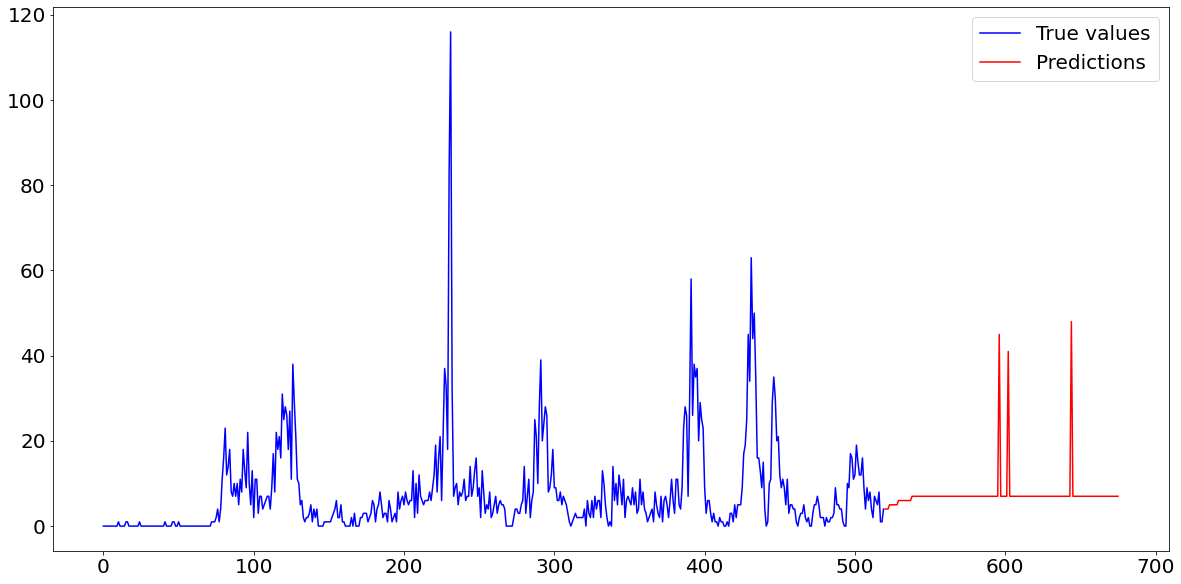

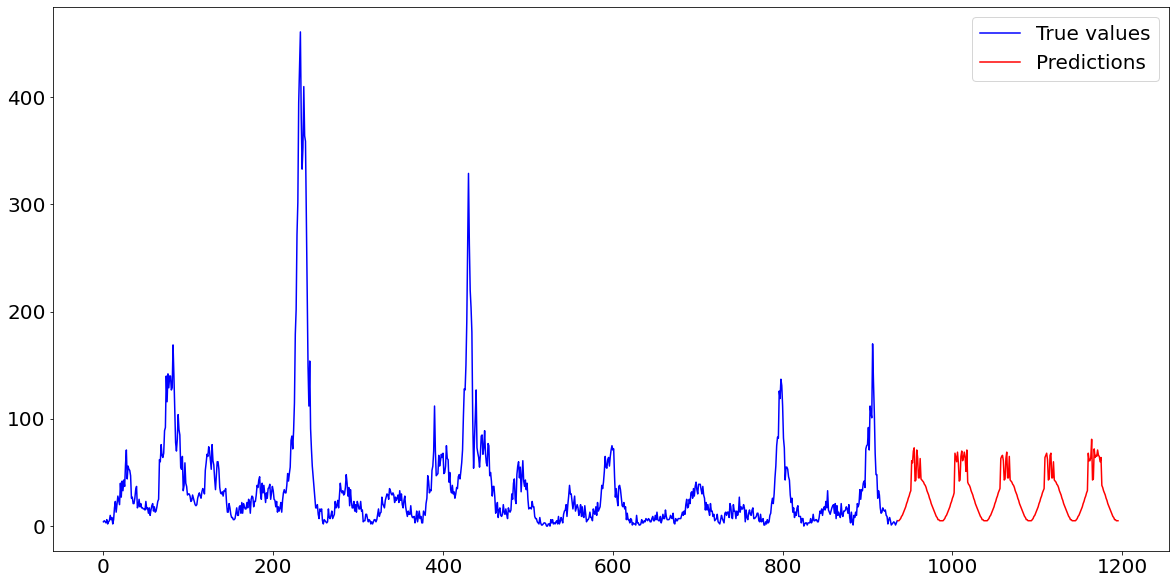

In [27]:
for city in test_pred_results.keys():
    y_pred = test_pred_results[city].copy()
    plot_total(y_pred, city)
save_prediction_results(test_pred_results)

The performance of the model is a bit disappointing. The outlined approach only barely beats the baseline approach outlined by the moderators of this challenge. This could be due to many things.

Firstly, looking at the out-of-sample prediction of Iquitos, we find that basically no seasonality is plotted through the TBATS model. That could be due to the fact that we can barely find any seasonality using 

## Appendix

[1] Andrea Dal Pozzolo. (2010). Comparison of Data Mining Techniques for Insurance Claim Prediction. https://dalpozz.github.io/static/pdf/Claim_prediction.pdf